In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)

In [ ]:
import pickle
from typing import Any, Literal

from flaml import AutoML
from sklearn.metrics import (
    confusion_matrix,
    make_scorer,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    FixedThresholdClassifier,
    KFold,
    PredefinedSplit,
    TunedThresholdClassifierCV,
)
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from hr_model import HrModel
from util import FeatureSetDataFrames


def specificity_score(y_true, y_pred) -> float:
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


def find_threshold_ref_specificity(model, X, y, *, verbose=False) -> float:
    hr_model = HrModel()

    ref_y_pred = hr_model.predict(X)
    ref_specificity = specificity_score(y, ref_y_pred)
    ref_recall = recall_score(y, ref_y_pred, zero_division=np.nan)

    y_pred_proba = model.predict_proba(X)
    thresholds = np.logspace(-5, 0, 100)

    for th in thresholds:
        y_pred = (y_pred_proba[:, 1] >= th).astype(int)
        specificity = specificity_score(y, y_pred)
        recall = recall_score(y, y_pred, zero_division=np.nan)
        if specificity >= ref_specificity:
            if verbose:
                print(f"Selected threshold: {th}")
                print(f"Selected specificity: {specificity}, recall: {recall}")
                print(f"Reference specificity: {ref_specificity}, recall: {ref_recall}")
            return th

    raise ValueError("No suitable threshold found!")


def find_threshold_ref_specificity_cv(model, df_train, df_val, cv, verbose=False):
    X, y = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    thresholds = []
    for train_idx, val_idx in cv.split(df_train):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th: int | float = find_threshold_ref_specificity(
            model, X_val, y_val, verbose=verbose
        )
        thresholds.append(th)

    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")

    model.fit(X, y)
    return FixedThresholdClassifier(model, threshold=best_threshold)


def youdens_j_score(y_true, y_pred) -> float:
    sensitivity = recall_score(y_true, y_pred, zero_division=np.nan)
    specificity = specificity_score(y_true, y_pred)
    return sensitivity + specificity - 1


TuningMethod = (
    Literal["balanced_accuracy"]
    | Literal["youden_index"]
    | Literal["cost_sensitive"]
    | Literal["ref_specificity"]
)


def create_dyad_cv(df_train: pd.DataFrame, n_splits: int = 5) -> PredefinedSplit:
    # Create 5-fold CV based on "dyad"
    dyad_labels = df_train["dyad"]
    skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = np.zeros(len(df_train), dtype=int)
    for fold_idx, (_, val_idx) in enumerate(
        skf.split(np.zeros(len(dyad_labels)), dyad_labels)
    ):
        folds[val_idx] = fold_idx
    return PredefinedSplit(folds)


def cost_sensitive_score(y, y_pred):
    cm = confusion_matrix(y, y_pred, labels=[0, 1])

    gain_matrix = np.array(
        [
            [0, -1],  # gain for false positives
            [-200, 0],  # gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


def train_model(
    df_train,
    df_val,
    hyperparams: dict[str, Any],
    tuning_method: TuningMethod,
):
    model = XGBClassifier(**hyperparams)
    X_train, y_train = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    cv = (
        create_dyad_cv(df_train)
        if len(df_val) == 0
        else PredefinedSplit(test_fold=[-1] * len(df_train) + [0] * len(df_val))
    )

    thresholds = np.logspace(-5, 0, 100)
    if tuning_method == "balanced_accuracy":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring="balanced_accuracy",
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "youden_index":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring=make_scorer(youdens_j_score),
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "cost_sensitive":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring=make_scorer(cost_sensitive_score),
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "ref_specificity":
        return find_threshold_ref_specificity_cv(
            model, df_train, df_val, cv, verbose=False
        )
    else:
        raise ValueError(f"Unknown tuning method: {tuning_method}")


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def train_and_get_dyad_models(
    df_population: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    week: int,
    dyad_models: dict[str, TunedThresholdClassifierCV],
    tuning_method: TuningMethod,
):
    min_week = df_test["therapy_week"].min()
    if week == min_week:
        return dyad_models

    new_dyad_models = {}
    bootstrap_level = df_test["dyad"].nunique()
    match mode:
        case "no_retrain":
            return dyad_models
        case "retrain_dyad":
            for dyad, dyad_df in tqdm(df_test.groupby("dyad"), leave=False):
                add_df = dyad_df[dyad_df["therapy_week"] < week]
                add_df = bootstrap(add_df, bootstrap_level)

                df_train = pd.concat(
                    [df_population, add_df[add_df["therapy_week"] < week - 1]]
                )
                df_val = add_df[add_df["therapy_week"] == week - 1]
                new_dyad_models[dyad] = train_model(
                    df_train,
                    df_val,
                    dyad_models[dyad].estimator.get_params(),
                    tuning_method,
                )
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(
    base_model,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    tuning_method: TuningMethod,
):
    dyad_models = {d: base_model for d in df_test["dyad"].unique()}
    weekly_results = []
    weekly_models = []
    weeks = df_test["therapy_week"].unique()
    weeks_iter = sorted(weeks[weeks >= 0])
    for week in tqdm(weeks_iter):
        dyad_models = train_and_get_dyad_models(
            df_train,
            df_test,
            mode,
            week,
            dyad_models=dyad_models,
            tuning_method=tuning_method,
        )
        weekly_models.append((week, dyad_models))
        week_df = df_test[df_test["therapy_week"] == week]

        week_pred_proba = np.empty((0, 2))
        week_preds = np.array([])
        week_trues = np.array([])
        week_thresholds = np.array([])

        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = model.predict(X)

            week_pred_proba = np.concatenate([week_pred_proba, y_pred_proba])
            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])
            threshold = (
                model.best_threshold_
                if isinstance(model, TunedThresholdClassifierCV)
                else 0.5
            )
            week_thresholds = np.append(week_thresholds, threshold)

        print(
            f"Week {week} sensitivity: {recall_score(week_trues, week_preds)}, specificity: {specificity_score(week_trues, week_preds)}"
        )
        weekly_results.append(
            (week, week_pred_proba, week_preds, week_trues, week_thresholds)
        )

    return weekly_results, weekly_models


supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]
feature_supersets = {
    "watch": [
        "hr",
        "activity",
        "sleep",
        "stress",
        "overnight_hrv",
    ],
    "demographic": [
        "child_demo",
        "parent_demo",
    ],
    "medical": [
        "medical",
        "therapy",
    ],
}


automl_settings = {
    "max_iter": 1,
    # "time_budget": 60,
    # "train_time_limit": 2,  # seconds
    # "pred_time_limit": 1,  # seconds
    # "task": "classification",
    # "metric": "log_loss",
    "early_stop": True,
}


def eval_model_on_feature_sets(
    supersets_to_test: list[list[str]],
    dfs: FeatureSetDataFrames,
    weeks: tuple[int, int],
    active_hours: tuple[int, int],
    estimator: str,
    mode: str,
    tuning_method: TuningMethod,
    verbose: bool = False,
) -> dict[str, Any]:
    feature_set_results = {}
    for supersets in supersets_to_test:
        name = "_".join(supersets)
        print(f"Feature sets: {name}")

        features = [fs for superset in supersets for fs in feature_supersets[superset]]
        combined_df = pd.concat(
            [
                dfs["index"],
                dfs["response"],
            ]
            + [dfs[fs] for fs in features],
            axis=1,
        )
        combined_df = combined_df[
            (
                combined_df["ActivityDateTime"].dt.hour.between(
                    active_hours[0], active_hours[1]
                )
            )
        ]
        combined_df = combined_df[
            combined_df["therapy_week"].between(weeks[0], weeks[1])
        ]

        df_train = combined_df[combined_df["Arm_Sham"]]
        df_test = combined_df[~combined_df["Arm_Sham"]]

        # Create 5-fold CV based on "dyad"
        X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
        automl = AutoML()
        automl.fit(
            X_train,
            y_train,
            **automl_settings,
            estimator_list=[estimator],
            eval_method="cv",
            split_type="group",
            groups=df_train["dyad"],
            verbose=verbose,
        )
        tuned_model = train_model(
            df_train,
            pd.DataFrame(),
            automl.best_config,
            tuning_method=tuning_method,
        )
        results, models = retrain_and_predict(
            tuned_model, df_train, df_test, mode=mode, tuning_method=tuning_method
        )

        data_dir = Path("./intermediate_data")
        data_dir.mkdir(parents=True, exist_ok=True)
        with open(
            data_dir / f"{estimator}_{tuning_method}_{mode}_{name}_results.pkl", "wb"
        ) as f:
            pickle.dump(results, f)

        feature_set_results[name] = results
    return feature_set_results

In [83]:
# Params
weeks = (0, 15)
active_hours = (7, 20)
tuning_method: TuningMethod = "balanced_accuracy"
# estimator = "xgboost"
estimator = "lrl2"

In [86]:
no_retrain_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    active_hours=active_hours,
    estimator=estimator,
    mode="no_retrain",
    tuning_method=tuning_method,
    verbose=True,
)

Feature sets: watch
[[0.99497183 0.00502817]
 [0.96936006 0.03063994]
 [0.99415257 0.00584743]
 ...
 [0.99167458 0.00832542]
 [0.99001251 0.00998749]
 [0.99339189 0.00660811]]


AssertionError: 

In [ ]:
import warnings

warnings.filterwarnings("ignore")

test_case = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]

retrain_dyad_results = eval_model_on_feature_sets(
    supersets_to_test=test_case,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    active_hours=active_hours,
    estimator=estimator,
    mode="retrain_dyad",
    tuning_method=tuning_method,
    verbose=False,
)

# Analysis


In [65]:
from pathlib import Path

tuning_method: TuningMethod = "balanced_accuracy"
model = "lrl2"

feature_sets = [
    "watch",
    "watch_demographic",
    "watch_medical",
    "watch_demographic_medical",
]
data_dir = Path("./intermediate_data")
no_retrain_results = {
    k: pickle.load(
        open(data_dir / f"{model}_{tuning_method}_no_retrain_{k}_results.pkl", "rb")
    )
    for k in feature_sets
}
retrain_dyad_results = {
    k: pickle.load(
        open(data_dir / f"{model}_{tuning_method}_retrain_dyad_{k}_results.pkl", "rb")
    )
    for k in feature_sets
}

full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df = full_df[
    (full_df["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1]))
]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

hr_model_results, _ = retrain_and_predict(
    HrModel(),
    full_df_train,
    full_df_test,
    mode="no_retrain",
    tuning_method=tuning_method,
)

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.36752136752136755, specificity: 0.6059304703476482
Week 1 sensitivity: 0.5700483091787439, specificity: 0.6181626187961985
Week 2 sensitivity: 0.44666666666666666, specificity: 0.5831464274271067
Week 3 sensitivity: 0.572463768115942, specificity: 0.6058795970953385
Week 4 sensitivity: 0.42528735632183906, specificity: 0.6171743823458863
Week 5 sensitivity: 0.43902439024390244, specificity: 0.6008938547486034
Week 6 sensitivity: 0.35, specificity: 0.570899209486166
Week 7 sensitivity: 0.6272727272727273, specificity: 0.5779780564263323
Week 8 sensitivity: 0.5212765957446809, specificity: 0.6010874938210579
Week 9 sensitivity: 0.5178571428571429, specificity: 0.582400416558188
Week 10 sensitivity: 0.5, specificity: 0.6184978431870084
Week 11 sensitivity: 0.5972222222222222, specificity: 0.5950517546074223
Week 12 sensitivity: 0.42424242424242425, specificity: 0.5962018297754367
Week 13 sensitivity: 0.627906976744186, specificity: 0.6001619433198381
Week 14 sensitiv

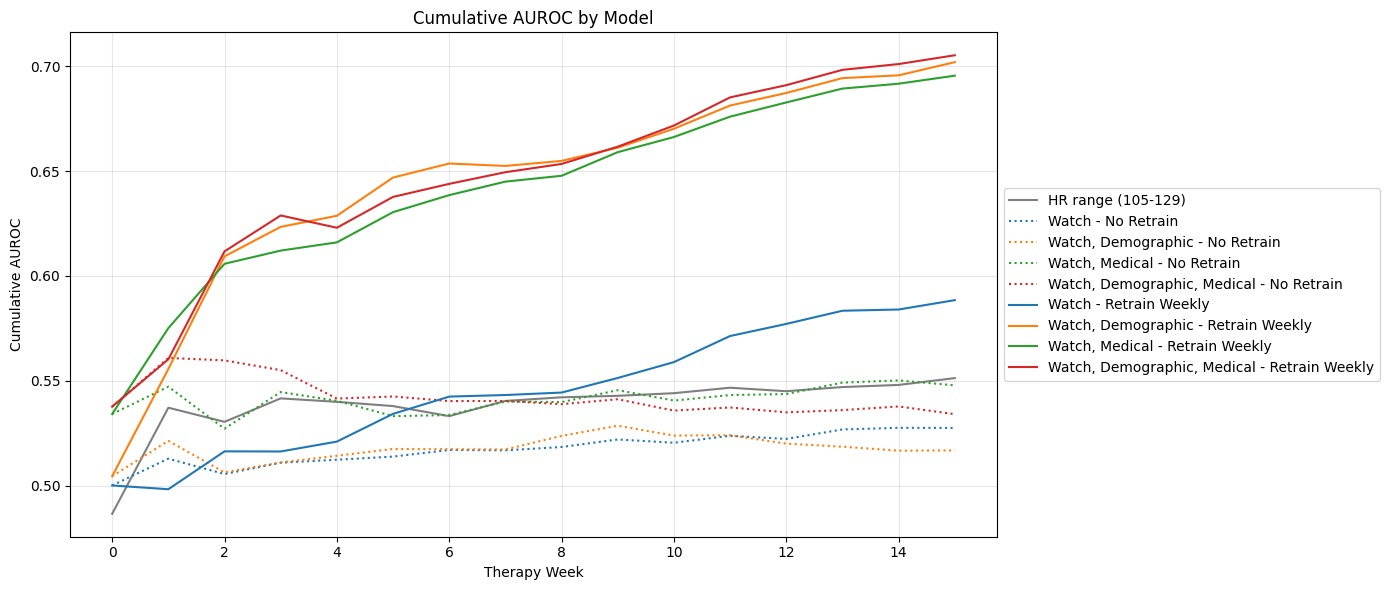

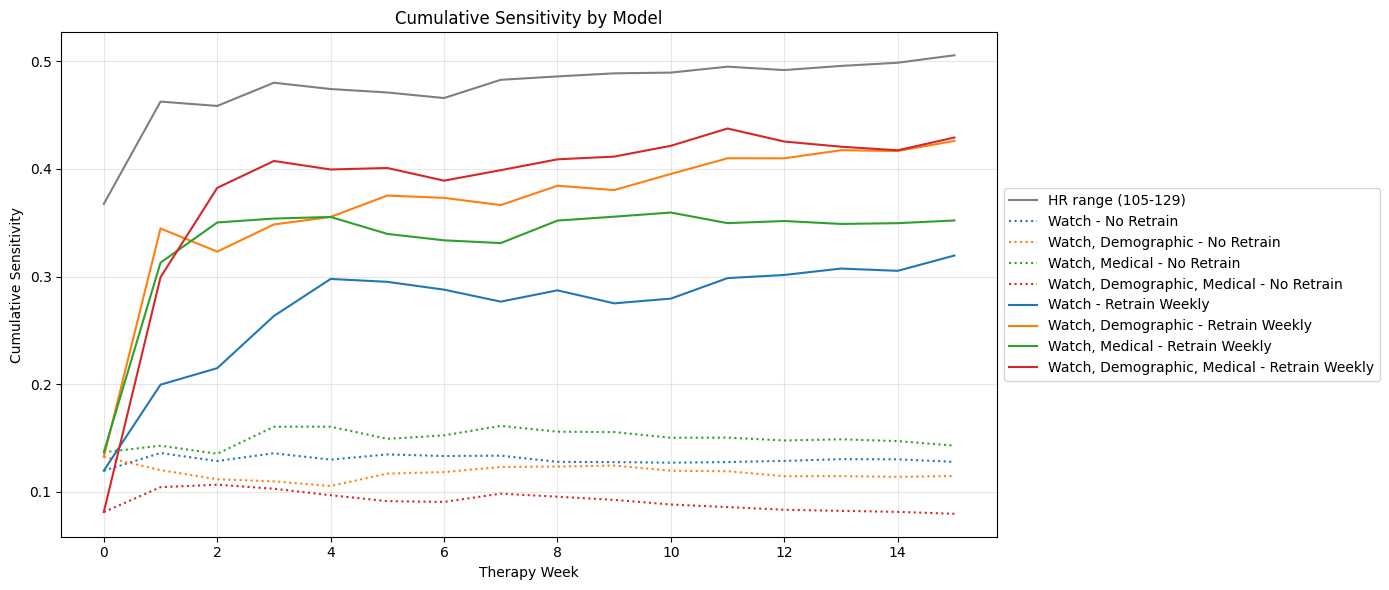

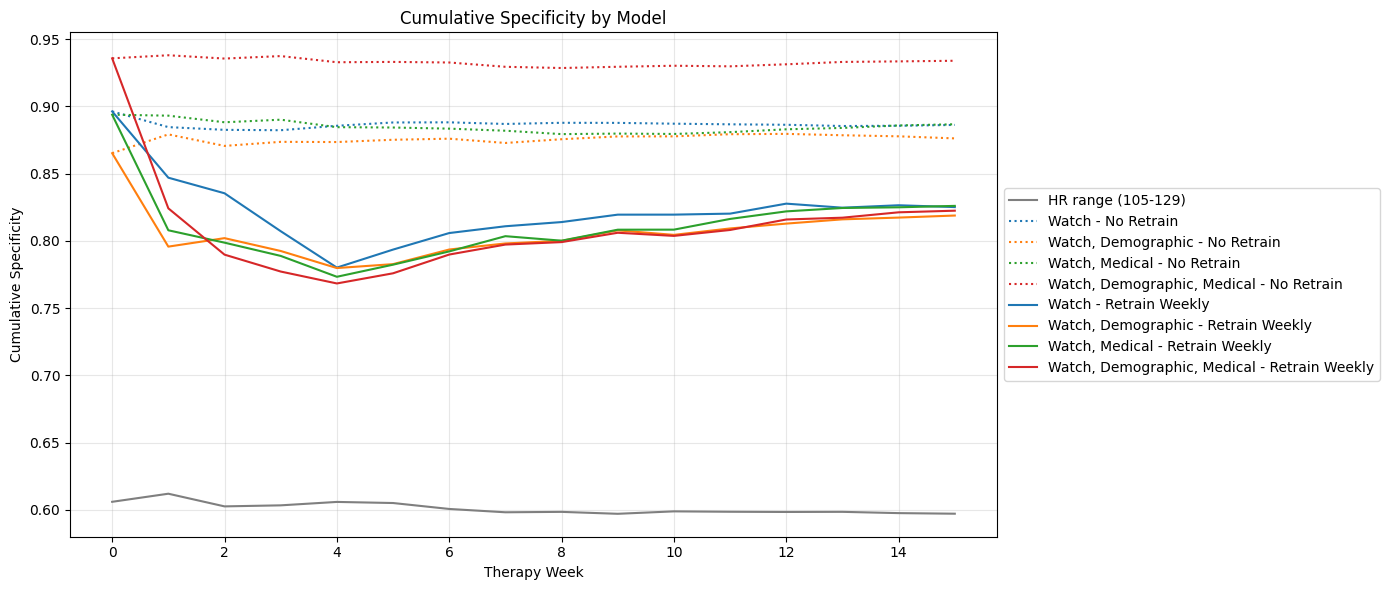

AUROC  \
Model                                Feature Set                               
HR range (reference)                 HR moving average                  0.55   
Static XGB                           Physiology                         0.53   
                                     Physiology, Demographic            0.52   
                                     Physiology, Medical                0.55   
                                     Physiology, Demographic, Medical   0.53   
Individualized XGB, retrained weekly Physiology                         0.59   
                                     Physiology, Demographic            0.70   
                                     Physiology, Medical                0.70   
                                     Physiology, Demographic, Medical   0.71   

                                                                       Sensitivity  \
Model                                Feature Set                                     
HR range (reference)                 HR moving average                        0.51   
Static XGB                           Physiology                               0.13   
                                     Physiology, Demographic                  0.11   
                                     Physiology, Medical                      0.14   
                                     Physiology, Demographic, Medical         0.08   
Individualized XGB, retrained weekly Physiology                               0.32   
                                     Physiology, Demographic                  0.43   
                                     Physiology, Medical                      0.35   
                                     Physiology, Demographic, Medical         0.43   

                                                                       Specificity  
Model                                Feature Set                                    
HR range (reference)                 HR moving average                        0.60  
Static XGB                           Physiology                               0.89  
                                     Physiology, Demographic                  0.88  
                                     Physiology, Medical                      0.89  
                                     Physiology, Demographic, Medical         0.93  
Individualized XGB, retrained weekly Physiology                               0.83  
                                     Physiology, Demographic                  0.82  
                                     Physiology, Medical                      0.83  
                                     Physiology, Demographic, Medical         0.82

In [66]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_weekly_cum_metric(metric_name, metric_fn):
    def weekly_cum_metric(results, metric_fn):
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])

            if metric_fn is roc_auc_score:
                metric = metric_fn(all_y_true, all_y_pred_proba[:, 1])
            else:
                metric = metric_fn(all_y_true, all_y_pred)
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_watch_cum_auc = weekly_cum_metric(no_retrain_results["watch"], metric_fn)
    no_retrain_demographic_cum_auc = weekly_cum_metric(
        no_retrain_results["watch_demographic"], metric_fn
    )
    no_retrain_medical_metric = weekly_cum_metric(
        no_retrain_results["watch_medical"], metric_fn
    )
    no_retrain_all_features_metric = weekly_cum_metric(
        no_retrain_results["watch_demographic_medical"], metric_fn
    )
    retrain_watch_cum_auc = weekly_cum_metric(retrain_dyad_results["watch"], metric_fn)
    retrain_demographic_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic"], metric_fn
    )
    retrain_medical_metric = weekly_cum_metric(
        retrain_dyad_results["watch_medical"], metric_fn
    )
    retrain_medical_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic_medical"], metric_fn
    )

    plt.figure(figsize=(14, 6))
    plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")

    plt.plot(*zip(*no_retrain_watch_cum_auc), label="Watch - No Retrain", linestyle=":")
    plt.plot(
        *zip(*no_retrain_demographic_cum_auc),
        label="Watch, Demographic - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_medical_metric),
        label="Watch, Medical - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_all_features_metric),
        label="Watch, Demographic, Medical - No Retrain",
        linestyle=":",
    )

    plt.plot(
        *zip(*retrain_watch_cum_auc), label="Watch - Retrain Weekly", color="tab:blue"
    )
    plt.plot(
        *zip(*retrain_demographic_cum_auc),
        label="Watch, Demographic - Retrain Weekly",
        color="tab:orange",
    )
    plt.plot(
        *zip(*retrain_medical_metric),
        label="Watch, Medical - Retrain Weekly",
        color="tab:green",
    )
    plt.plot(
        *zip(*retrain_medical_cum_auc),
        label="Watch, Demographic, Medical - Retrain Weekly",
        color="tab:red",
    )

    plt.xlabel("Therapy Week")
    plt.ylabel(f"Cumulative {metric_name}")
    plt.title(f"Cumulative {metric_name} by Model")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def get_final_metrics():
    def get_final_metric(results, metric_fn):
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for _, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
        if metric_fn is roc_auc_score:
            return metric_fn(all_y_true, all_y_pred_proba[:, 1])
        else:
            return metric_fn(all_y_true, all_y_pred)

    models = [
        ("HR range (reference)", "HR moving average", hr_model_results),
        ("Static XGB", "Physiology", no_retrain_results["watch"]),
        (
            "Static XGB",
            "Physiology, Demographic",
            no_retrain_results["watch_demographic"],
        ),
        ("Static XGB", "Physiology, Medical", no_retrain_results["watch_medical"]),
        (
            "Static XGB",
            "Physiology, Demographic, Medical",
            no_retrain_results["watch_demographic_medical"],
        ),
        (
            "Individualized XGB, retrained weekly",
            "Physiology",
            retrain_dyad_results["watch"],
        ),
        (
            "Individualized XGB, retrained weekly",
            "Physiology, Demographic",
            retrain_dyad_results["watch_demographic"],
        ),
        (
            "Individualized XGB, retrained weekly",
            "Physiology, Medical",
            retrain_dyad_results["watch_medical"],
        ),
        (
            "Individualized XGB, retrained weekly",
            "Physiology, Demographic, Medical",
            retrain_dyad_results["watch_demographic_medical"],
        ),
    ]

    rows = []
    for model, feature_set, results in models:
        auroc = get_final_metric(results, roc_auc_score)
        sensitivity = get_final_metric(results, recall_score)
        specificity = get_final_metric(results, specificity_score)
        rows.append(
            {
                "Model": model,
                "Feature Set": feature_set,
                "AUROC": round(auroc, 2),
                "Sensitivity": round(sensitivity, 2),
                "Specificity": round(specificity, 2),
            }
        )
    return pd.DataFrame(rows).set_index(["Model", "Feature Set"])


plot_weekly_cum_metric("AUROC", roc_auc_score)
plot_weekly_cum_metric("Sensitivity", recall_score)
plot_weekly_cum_metric("Specificity", specificity_score)
# And paste into Word
get_final_metrics().to_clipboard()
get_final_metrics()

In [ ]:
# # How much can we improve the HR range model

# import itertools

# from sklearn.metrics import roc_auc_score

# from hr_model import HrModel

# full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
# full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
# full_df_train = full_df[full_df["Arm_Sham"]]
# full_df_test = full_df[~full_df["Arm_Sham"]]

# X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

# best_auc = -1
# best_hr_low = None
# best_hr_high = None
# best_sens = None
# best_spec = None

# hr_lows = range(50, 150, 2)
# hr_highs = range(100, 200, 2)

# for combo in tqdm(list(itertools.product(hr_lows, hr_highs))):
#     hr_low, hr_high = combo

#     if hr_high <= hr_low:
#         continue
#     # Predict using HR range
#     y_pred = (
#         (full_df_train["hr_moving_avg_10m"] >= hr_low)
#         & (full_df_train["hr_moving_avg_10m"] <= hr_high)
#     ).astype(int)
#     y_true = y_train

#     # Only evaluate where hr_moving_avg_10m is not NaN
#     mask = full_df_train["hr_moving_avg_10m"].notna()
#     if mask.sum() == 0:
#         continue

#     auc = roc_auc_score(y_true[mask], y_pred[mask])
#     sens = recall_score(y_true[mask], y_pred[mask])
#     spec = specificity_score(y_true[mask], y_pred[mask])

#     if auc > best_auc:
#         best_auc = auc
#         best_hr_low = hr_low
#         best_hr_high = hr_high
#         best_sens = sens
#         best_spec = spec

# print(f"Best HR range: {best_hr_low}-{best_hr_high}")
# print(f"ROC-AUC: {best_auc:.3f}")
# print(f"Sensitivity: {best_sens:.3f}")
# print(f"Specificity: {best_spec:.3f}")